# Init

In [3]:
import duckdb
import pandas as pd 
import numpy as np
import logging

In [4]:
cd ..

/Users/wliao0504/code/clif/CLIF-MIMIC


/Users/wliao0504/code/clif/CLIF-MIMIC/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
pwd

'/Users/wliao0504/code/clif/CLIF-MIMIC'

In [6]:
#%load_ext autoreload
#%autoreload 1
from src.utils import check_duplicates, find_duplicates, read_from_rclif, clif_table_pathfinder, \
    mimic_table_pathfinder

from src.utils import construct_mapper_dict, fetch_mimic_events, load_mapping_csv, \
    get_relevant_item_ids, find_duplicates, rename_and_reorder_cols, save_to_rclif, \
    convert_and_sort_datetime, setup_logging  

loaded configuration from /Users/wliao0504/code/clif/CLIF-MIMIC/src/../config/config.json


In [7]:
setup_logging()

2025-04-27 12:57:39,585 - INFO - initialized logging at logs/etl.log


### load hamilton pipeline

In [42]:
import importlib
from src.tables import respiratory_support 
importlib.reload(respiratory_support)

from src import utils
importlib.reload(utils)

loaded configuration from /Users/wliao0504/code/clif/CLIF-MIMIC/src/../config/config.json


<module 'src.utils' from '/Users/wliao0504/code/clif/CLIF-MIMIC/src/utils.py'>

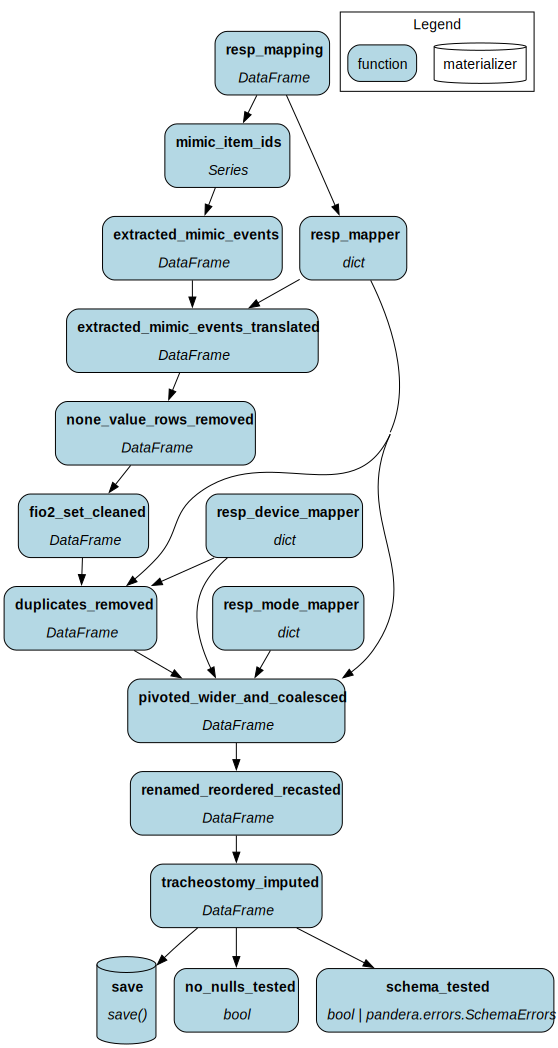

In [43]:
from hamilton import driver

dr = (
    driver.Builder()
    .with_modules(respiratory_support)
    # .with_cache()
    .build()
)
dr.display_all_functions(orient = "TB")

# Utils

In [ ]:
# TODO -- add this to the pipeline as a qa check
def find_and_report_all_null_rows(df: pd.DataFrame):
    """Report the rows with null in device_name, mode_name, vent_brand_name, and all value fields."""
    df["all_value_na"] = df.loc[:, "fio2_set": "mean_airway_pressure_obs"].isna().all(axis=1)
    mask = (
        (df["device_name"].isna())
        & (df["mode_name"].isna())
        & (df["vent_brand_name"].isna())
        & (df["all_value_na"] == True)
    )
    print(f"{mask.sum()} ({mask.mean()*100:.2f}%) rows have null in device_name, vent_brand_name, mode_name, and all value fields.")
    return df[mask]

# Dev

## Testing

In [44]:
results = respiratory_support._test()

2025-04-27 14:46:47,844 - INFO - testing all...
2025-04-27 14:46:47,846 - INFO - initialized logging at logs/etl.log
2025-04-27 14:46:47,851 - INFO - parsing the mapping files to identify relevant items and fetch corresponding events...
2025-04-27 14:46:47,852 - INFO - querying the d_items table to identify which event tables to be separately queried for 31 items
2025-04-27 14:46:47,855 - INFO - identified 2 event tables to be separately queried: ['chartevents', 'procedureevents']
2025-04-27 14:46:47,855 - INFO - fetching events from chartevents table for 29 items
2025-04-27 14:46:54,391 - INFO - fetched 13719827 events from chartevents table for 29 items
2025-04-27 14:46:54,393 - INFO - fetching events from procedureevents table for 2 items
2025-04-27 14:46:54,406 - INFO - fetched 680 events from procedureevents table for 2 items
2025-04-27 14:46:54,659 - INFO - concatenated 13720507 events from 2 event table(s)
2025-04-27 14:46:55,331 - INFO - removing rows where O2 Delivery Device(s

{'no_nulls_tested': True, 'schema_tested': True}


In [45]:
error = results["schema_tested"]
print(error)

True


In [46]:
error.failure_cases

AttributeError: 'bool' object has no attribute 'failure_cases'

In [ ]:
error.data.value_counts(["mode_category"])

mode_category                    
Pressure Support/CPAP                385772
Assist Control-Volume Control        208958
Pressure-Regulated Volume Control    182094
Other                                 34232
Volume Support                        32439
Pressure Control                      13999
SIMV                                   2896
Blow by                                 135
Name: count, dtype: int64

## Check NA

In [5]:
resp_f = read_from_rclif("respiratory_support")

In [ ]:
resp_f

In [162]:
# get the final df which is the output of the `transform` step in the pipeline
resp_f = p.data["transform"]
print(len(resp_f))
resp_f.head()

2148372


,hospitalization_id,recorded_dttm,device_name,device_category,vent_brand_name,mode_name,mode_category,tracheostomy,fio2_set,lpm_set,...,peak_inspiratory_pressure_set,inspiratory_time_set,peep_set,tidal_volume_obs,resp_rate_obs,plateau_pressure_obs,peak_inspiratory_pressure_obs,peep_obs,minute_vent_obs,mean_airway_pressure_obs
0,20000094,2150-03-02 15:34:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,False,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20000094,2150-03-02 20:00:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,False,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20000147,2121-08-30 22:00:00,Endotracheal tube,IMV,NaN,CMV/ASSIST/AutoFlow,Assist Control-Volume Control,False,1.0,NaN,...,NaN,0.9,5.0,524.0,16.0,23.0,25.0,NaN,9.77,11.0
3,20000147,2121-08-30 23:00:00,NaN,None,Drager,CMV/ASSIST/AutoFlow,Assist Control-Volume Control,False,NaN,NaN,...,NaN,0.9,10.0,612.0,18.0,22.0,24.0,10.2,9.90,10.0
4,20000147,2121-08-31 00:00:00,NaN,None,NaN,NaN,NaN,False,0.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# create a new column called "all_value_na" if all the columns starting from "tracheostomy" are NA
resp_f["all_value_na"] = resp_f.loc[:, "fio2_set": "mean_airway_pressure_obs"].isna().all(axis=1)
resp_f.head()

,hospitalization_id,recorded_dttm,device_name,device_category,vent_brand_name,mode_name,mode_category,tracheostomy,fio2_set,lpm_set,...,inspiratory_time_set,peep_set,tidal_volume_obs,resp_rate_obs,plateau_pressure_obs,peak_inspiratory_pressure_obs,peep_obs,minute_vent_obs,mean_airway_pressure_obs,all_value_na
0,20000094,2150-03-02 15:34:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,False,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,20000094,2150-03-02 20:00:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,False,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,20000147,2121-08-30 22:00:00,Endotracheal tube,IMV,NaN,CMV/ASSIST/AutoFlow,Assist Control-Volume Control,False,1.0,NaN,...,0.9,5.0,524.0,16.0,23.0,25.0,NaN,9.77,11.0,False
3,20000147,2121-08-30 23:00:00,NaN,None,Drager,CMV/ASSIST/AutoFlow,Assist Control-Volume Control,False,NaN,NaN,...,0.9,10.0,612.0,18.0,22.0,24.0,10.2,9.90,10.0,False
4,20000147,2121-08-31 00:00:00,NaN,None,NaN,NaN,NaN,False,0.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [66]:
# a smaller subsect of important columns to inspect
resp_f2: pd.DataFrame = resp_f[
    [
        "hospitalization_id",
        "recorded_dttm",
        "device_name", "device_category",
        "vent_brand_name",
        "mode_name", "mode_category",
        "all_value_na",
    ]
]
resp_f2.head()

,hospitalization_id,recorded_dttm,device_name,device_category,vent_brand_name,mode_name,mode_category,all_value_na
0,20000094,2150-03-02 15:34:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,False
1,20000094,2150-03-02 20:00:00,Nasal cannula,Nasal Cannula,NaN,NaN,NaN,False
2,20000147,2121-08-30 22:00:00,Endotracheal tube,IMV,NaN,CMV/ASSIST/AutoFlow,Assist Control-Volume Control,False
3,20000147,2121-08-30 23:00:00,NaN,None,Drager,CMV/ASSIST/AutoFlow,Assist Control-Volume Control,False
4,20000147,2121-08-31 00:00:00,NaN,None,NaN,NaN,NaN,False


Notice there are both 'None' and NaN (null) in `device_name`. NaN are likely the rows with partial values while None likely correspond to rows that are completely NA -- need to check this.

In [67]:
resp_f.value_counts(["device_name"], dropna=False)

device_name            
Endotracheal tube          633302
NaN                        542983
Nasal cannula              519136
Tracheostomy tube          127409
Aerosol-cool                74701
Trach mask                  50219
High flow nasal cannula     47831
Face tent                   43960
Bipap mask                  25813
High flow neb               18577
Oxymizer                    16981
Non-rebreather              13610
CPAP mask                   10764
T-piece                      7855
Venti mask                   6275
Medium conc mask             4718
Other                        4509
Ultrasonic neb                 20
Vapomist                        6
Name: count, dtype: int64

In [68]:
resp_f.value_counts(["mode_name"], dropna=False)

mode_name                        
NaN                                  1273997
CPAP/PSV                              203473
CMV/ASSIST/AutoFlow                   184695
APV (cmv)                             173135
SPONT                                 163902
ASV                                    32439
CMV/ASSIST                             19652
MMV/PSV/AutoFlow                       13344
Standby                                11997
Spontaneous (S)                        11872
PSV/SBT                                11357
P-CMV                                   8770
PRVC/AC                                 5342
PCV+Assist                              4336
CPAP/PSV+ApnVol                         3583
VS                                      3471
Spontaneous/Timed (S/T) (Back up)       2374
Ambient                                 2150
SIMV/PSV/AutoFlow                       2033
MMV/PSV                                 1981
NIV                                     1948
APRV                 

In [82]:
print(f"{resp_f2.all_value_na.sum()} ({resp_f2.all_value_na.mean()*100:.1f}%) rows that have NA in all values fields.")

mask = resp_f2["device_name"].isna()
print(f"{mask.sum()} ({mask.mean()*100:.1f}%) rows have NaN for `device_name`")

mask = resp_f2["device_name"] == "None"
print(f"{mask.sum()} ({mask.mean()*100:.1f}%) rows have 'None' for `device_name`")

176044 (8.2%) rows that have NA in all values fields.
542983 (25.3%) rows have NaN for `device_name`
0 (0.0%) rows have 'None' for `device_name`


In [70]:
# filter rows with any NA -- in either device_name or across all value fields
mask = resp_f2["device_name"].isna() | (resp_f2["device_name"] == "None") | resp_f2["all_value_na"]
resp_f3 = resp_f2[mask]
resp_f3.head()

,hospitalization_id,recorded_dttm,device_name,device_category,vent_brand_name,mode_name,mode_category,all_value_na
3,20000147,2121-08-30 23:00:00,NaN,None,Drager,CMV/ASSIST/AutoFlow,Assist Control-Volume Control,False
4,20000147,2121-08-31 00:00:00,NaN,None,NaN,NaN,NaN,False
34,20001305,2178-03-26 17:30:00,NaN,None,NaN,APV (cmv),Pressure-Regulated Volume Control,False
35,20001305,2178-03-26 17:45:00,NaN,None,NaN,NaN,NaN,False
43,20001361,2143-05-04 17:04:00,NaN,None,NaN,NaN,NaN,False


In [164]:
all_null_rows = find_and_report_all_null_rows(resp_f)
all_null_rows.head()

677 (0.03%) rows have null in device_name, vent_brand_name, mode_name, and all value fields.


,hospitalization_id,recorded_dttm,device_name,device_category,vent_brand_name,mode_name,mode_category,tracheostomy,fio2_set,lpm_set,...,inspiratory_time_set,peep_set,tidal_volume_obs,resp_rate_obs,plateau_pressure_obs,peak_inspiratory_pressure_obs,peep_obs,minute_vent_obs,mean_airway_pressure_obs,all_value_na
1657,20013496,2161-11-15 18:36:00,NaN,None,NaN,NaN,NaN,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4713,20024364,2129-07-28 12:59:00,NaN,None,NaN,NaN,NaN,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
11842,20063453,2196-11-06 08:03:00,NaN,None,NaN,NaN,NaN,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
14101,20068469,2131-11-12 14:01:00,NaN,None,NaN,NaN,NaN,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
15701,20077086,2121-10-01 11:01:00,NaN,None,NaN,NaN,NaN,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [165]:
mask = all_null_rows['tracheostomy'] == False
mask.sum()

np.int64(0)

In [172]:
print(resp_f["fio2_set"].min())
print(resp_f["fio2_set"].max())
print(resp_f["fio2_set"].mean())


0.2
1.0
0.49026212251411716


## clean fio2_set

In [153]:
df_clean_fio2_set = p.data['_clean_fio2_set']
df_clean_fio2_set.head()

,itemid,label,hadm_id,stay_id,time,value,valueuom,variable
0,223834,O2 Flow,23251352,31494479,2141-12-18 00:00:00,4,L/min,lpm_set
1,226732,O2 Delivery Device(s),23251352,31494479,2141-12-18 00:00:00,Nasal cannula,None,device_name
2,223834,O2 Flow,23251352,31494479,2141-12-18 03:00:00,3,L/min,lpm_set
3,226732,O2 Delivery Device(s),23251352,31494479,2141-12-18 03:00:00,Nasal cannula,None,device_name
4,223834,O2 Flow,23251352,31494479,2141-12-18 04:00:00,2,L/min,lpm_set


In [154]:
mask = df_clean_fio2_set['value'].isna()
print(f"{mask.sum()} ({mask.mean()*100:.2f}%) rows have NA for `value`")

0 (0.00%) rows have NA for `value`


In [155]:
mask = df_clean_fio2_set['variable'] == 'fio2_set'
df_clean_fio2_set[mask]

,itemid,label,hadm_id,stay_id,time,value,valueuom,variable
10,223835,Inspired O2 Fraction,23251352,31494479,2141-12-17 14:25:00,1.0,None,fio2_set
19,223835,Inspired O2 Fraction,23251352,31494479,2141-12-17 14:27:00,1.0,None,fio2_set
29,223835,Inspired O2 Fraction,23251352,31494479,2141-12-17 15:00:00,0.4,None,fio2_set
31,223835,Inspired O2 Fraction,23251352,31494479,2141-12-17 16:00:00,0.4,None,fio2_set
42,223835,Inspired O2 Fraction,29242151,30213599,2159-02-21 09:00:00,0.3,None,fio2_set
...,...,...,...,...,...,...,...,...
13719694,223835,Inspired O2 Fraction,26785317,32336619,2148-11-20 12:00:00,0.4,None,fio2_set
13719731,223835,Inspired O2 Fraction,21033226,38978960,2164-09-16 08:00:00,0.6,None,fio2_set
13719742,223835,Inspired O2 Fraction,21033226,38978960,2164-09-16 12:00:00,0.6,None,fio2_set
13719766,223835,Inspired O2 Fraction,25160854,30973412,2183-02-21 12:00:00,0.5,None,fio2_set


In [157]:
df_remove_none_value_rows = p.data['_remove_none_value_rows']
mask = df_remove_none_value_rows['value'].isna()
print(f"{mask.sum()} ({mask.mean()*100:.2f}%) rows have NA for `value`")
df_remove_none_value_rows.head()

0 (0.00%) rows have NA for `value`


,itemid,label,hadm_id,stay_id,time,value,valueuom,variable
0,223834,O2 Flow,23251352,31494479,2141-12-18 00:00:00,4,L/min,lpm_set
1,226732,O2 Delivery Device(s),23251352,31494479,2141-12-18 00:00:00,Nasal cannula,None,device_name
2,223834,O2 Flow,23251352,31494479,2141-12-18 03:00:00,3,L/min,lpm_set
3,226732,O2 Delivery Device(s),23251352,31494479,2141-12-18 03:00:00,Nasal cannula,None,device_name
4,223834,O2 Flow,23251352,31494479,2141-12-18 04:00:00,2,L/min,lpm_set


In [178]:
df = p.data['_remove_none_value_rows']
query = '''
SELECT *,
CASE
    WHEN CAST(value AS DOUBLE) >= 20 AND CAST(value AS DOUBLE) <= 100 THEN CAST(value AS DOUBLE) / 100
    WHEN CAST(value AS DOUBLE) > 1 AND CAST(value AS DOUBLE) < 20 THEN NULL
    WHEN CAST(value AS DOUBLE) > 0.2 AND CAST(value AS DOUBLE) <= 1 THEN CAST(value AS DOUBLE)
    ELSE NULL 
END AS value
FROM df
WHERE variable = 'fio2_set'
'''
df2 = duckdb.query(query).df()
mask = df2['value'].isna()
print(f"{mask.sum()} ({mask.mean()*100:.2f}%) rows have NA for `value`")
# df2.dropna(subset=['value'], inplace=True)

0 (0.00%) rows have NA for `value`


In [ ]:
df2

In [158]:
p._clean_fio2_set(df_remove_none_value_rows)

/Users/wliao0504/Library/Mobile Documents/com~apple~CloudDocs/Repo/hca-lab/CLIF-MIMIC/src/tables/respiratory_support.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # RESUME TODO convert this into SQL syntax to make it more readable


,itemid,label,hadm_id,stay_id,time,value,valueuom,variable
0,223834,O2 Flow,23251352,31494479,2141-12-18 00:00:00,4,L/min,lpm_set
1,226732,O2 Delivery Device(s),23251352,31494479,2141-12-18 00:00:00,Nasal cannula,None,device_name
2,223834,O2 Flow,23251352,31494479,2141-12-18 03:00:00,3,L/min,lpm_set
3,226732,O2 Delivery Device(s),23251352,31494479,2141-12-18 03:00:00,Nasal cannula,None,device_name
4,223834,O2 Flow,23251352,31494479,2141-12-18 04:00:00,2,L/min,lpm_set
...,...,...,...,...,...,...,...,...
675,225448,Percutaneous Tracheostomy,27477323,39588351,2139-04-23 09:06:00,1.0,None,tracheostomy
676,225448,Percutaneous Tracheostomy,25790502,33193862,2145-08-28 16:06:00,1.0,None,tracheostomy
677,225448,Percutaneous Tracheostomy,27671558,33228100,2151-01-27 13:01:00,1.0,None,tracheostomy
678,225448,Percutaneous Tracheostomy,27669986,36058123,2177-07-15 09:30:00,1.0,None,tracheostomy


In [118]:
mask = (src_df['hadm_id'] == 20027733) \
    & (src_df['time'] == pd.to_datetime('2112-06-14 02:00:00'))
src_df[mask]

,itemid,label,hadm_id,stay_id,time,value,valueuom,variable
8406861,223835,Inspired O2 Fraction,20027733,33157970,2112-06-14 02:00:00,0,None,fio2_set


In [161]:
df = p.data['_remove_none_value_rows']
mask = df['value'].isna()
print(f"{mask.sum()} ({mask.mean()*100:.2f}%) rows have NA for `value`")
df2 = df[mask & (df['hadm_id'] == 20027733)]
df2.head()

0 (0.00%) rows have NA for `value`


,itemid,label,hadm_id,stay_id,time,value,valueuom,variable


In [143]:
df.loc[df['variable'] == 'fio2_set', 'value'] = df.loc[df['variable'] == 'fio2_set', 'value'].apply(_clean_fio2_set_helper)
mask = df['value'].isna()
print(f"{mask.sum()} ({mask.mean()*100:.2f}%) rows have NA for `value`")
df2 = df[mask & (df['hadm_id'] == 20027733)]
df2.head()

24 (0.00%) rows have NA for `value`


,itemid,label,hadm_id,stay_id,time,value,valueuom,variable


## 'None' value in untransformed MIMIC data

verify from the untransformed MIMIC data that 'None' value were already occuring:

In [73]:
src_df.head()

,itemid,label,hadm_id,stay_id,time,value,valueuom,variable
0,223834,O2 Flow,25563031,31205490,2110-04-12 06:00:00,2,L/min,lpm_set
1,226732,O2 Delivery Device(s),25563031,31205490,2110-04-12 06:00:00,Nasal cannula,None,device_name
2,223834,O2 Flow,25563031,31205490,2110-04-11 16:07:00,2,L/min,lpm_set
3,226732,O2 Delivery Device(s),25563031,31205490,2110-04-11 16:07:00,Nasal cannula,None,device_name
4,223835,Inspired O2 Fraction,26133978,39698942,2134-12-06 08:00:00,40,None,fio2_set


In [74]:
# find all the rows with value = None:
cond = src_df["value"] == 'None'
print(f"{cond.sum()} ({cond.mean()*100:.1f}%) has None value")
null_val_rows = src_df[cond]
null_val_rows.head()

398249 (2.9%) has None value


,itemid,label,hadm_id,stay_id,time,value,valueuom,variable
286,226732,O2 Delivery Device(s),23559586,38383343,2137-08-27 13:00:00,None,None,device_name
287,226732,O2 Delivery Device(s),23559586,38383343,2137-08-27 17:17:00,None,None,device_name
1022,226732,O2 Delivery Device(s),27793700,34672098,2162-02-20 12:00:00,None,None,device_name
1023,226732,O2 Delivery Device(s),27793700,34672098,2162-02-20 16:00:00,None,None,device_name
1724,226732,O2 Delivery Device(s),23251352,31494479,2141-12-18 11:00:00,None,None,device_name


And all of these occur on the same variable:

In [77]:
null_val_rows.value_counts(["variable", "label"])

variable     label                
device_name  O2 Delivery Device(s)    398249
Name: count, dtype: int64

test which dropping is faster:

In [75]:
cond = src_df["value"] == 'None'
_ =src_df[~cond]

In [76]:
_ = src_df.query("value != 'None'")

also check our mapping didn't introduce any redundant stuff:

In [78]:
p.resp_mapper

{226732: 'device_name',
 223835: 'fio2_set',
 220339: 'peep_set',
 224685: 'tidal_volume_obs',
 224687: 'minute_vent_obs',
 224697: 'mean_airway_pressure_obs',
 224695: 'peak_inspiratory_pressure_obs',
 223834: 'lpm_set',
 223848: 'vent_brand_name',
 224690: 'resp_rate_obs',
 223849: 'mode_name',
 224688: 'resp_rate_set',
 224684: 'tidal_volume_set',
 224738: 'inspiratory_time_set',
 224686: 'tidal_volume_obs',
 224701: 'pressure_support_set',
 224696: 'plateau_pressure_obs',
 229314: 'mode_name',
 224691: 'flow_rate_set',
 224700: 'peep_obs',
 225448: 'tracheostomy',
 226237: 'tracheostomy',
 227287: 'lpm_set',
 224422: 'resp_rate_obs',
 224421: 'tidal_volume_obs',
 227577: 'mode_name',
 227579: 'peep_set',
 227580: 'peak_inspiratory_pressure_set',
 227582: 'flow_rate_set',
 224702: 'pressure_control_set',
 227581: 'resp_rate_set',
 None: None,
 'None': None}

In [ ]:
p.resp_mode_mapper

{'CPAP/PSV': 'Pressure Support/CPAP',
 'CMV/ASSIST/AutoFlow': 'Assist Control-Volume Control',
 'CMV/ASSIST': 'Assist Control-Volume Control',
 'MMV/PSV/AutoFlow': 'Other',
 'PSV/SBT': 'Pressure Support/CPAP',
 'PRVC/AC': 'Pressure-Regulated Volume Control',
 'PCV+Assist': 'Pressure Control',
 'CPAP/PSV+ApnVol': 'Pressure-Regulated Volume Control',
 'SIMV/PSV/AutoFlow': 'SIMV',
 'MMV/PSV': 'Other',
 'CPAP': 'Pressure Support/CPAP',
 'APRV': 'Other',
 'CMV/AutoFlow': 'Assist Control-Volume Control',
 'CPAP/PPS': 'Pressure Support/CPAP',
 'CPAP/PSV+ApnPres': 'Pressure Support/CPAP',
 'VOL/AC': 'Assist Control-Volume Control',
 'PCV+': 'Pressure Control',
 'CMV': 'Assist Control-Volume Control',
 'PCV+/PSV': 'Pressure Control',
 'PRES/AC': 'Assist Control-Volume Control',
 'SIMV/PSV': 'SIMV',
 'APV (cmv)': 'Pressure-Regulated Volume Control',
 'SPONT': 'Pressure Support/CPAP',
 'MMV': 'Other',
 'Apnea Ventilation': 'Blow by',
 'APRV/Biphasic+ApnVol': 'Other',
 'MMV/AutoFlow': 'Other',
 'A

In [80]:
p.resp_device_mapper

{'Endotracheal tube': 'IMV',
 'Nasal cannula': 'Nasal Cannula',
 'Tracheostomy tube': 'IMV',
 'Aerosol-cool': 'Face Mask',
 'Face tent': 'Face Mask',
 'Trach mask': 'Trach Collar',
 'High flow nasal cannula': 'High Flow NC',
 'Bipap mask': 'NIPPV',
 'High flow neb': 'High Flow NC',
 'Non-rebreather': 'Face Mask',
 'CPAP mask': 'CPAP',
 'Venti mask': 'Face Mask',
 'Other': 'Other',
 'Medium conc mask': 'Face Mask',
 'Oxymizer': 'Face Mask',
 'T-piece': 'Other',
 'Ultrasonic neb': 'Other',
 'Vapomist': 'Other',
 nan: nan,
 None: None,
 'None': None}

In [ ]:
resp_mapping = load_mapping_csv("respiratory_support")
resp_mapping.head()

,variable,itemid,label,abbreviation,linksto,category,unitname,param_type,count,value_instances,note / comment,status,latest update date,Unnamed: 13,variables,count.1,itemid_prio,label_prio,note
0,MAPPED ELSEWHERE,220210,Respiratory Rate,RR,chartevents,Respiratory,insp/min,Numeric,6393762,"Max: 2355560.0, Min: 0.0, Mean: 20.45996459206...",mapped in vitals,coded/validated by K. Smith,"July 2, 2024",NaN,tracheostomy,2.0,225448.0,Percutaneous Tracheostomy,likely no conflict
1,MAPPED ELSEWHERE,220277,O2 saturation pulseoxymetry,SpO2,chartevents,Respiratory,%,Numeric,6324341,"Max: 9900000.0, Min: -272.0, Mean: 104.8276359...",mapped in vitals,coded/validated by K. Smith,"July 2, 2024",NaN,fio2_set,1.0,NaN,NaN,NaN
2,device_name,226732,O2 Delivery Device(s),O2 Delivery Device(s),chartevents,Respiratory,NaN,Text,1536870,"""{'Endotracheal tube': 467931, 'Nasal cannula'...",NaN,coded/validated by K. Smith,"July 2, 2024",NaN,lpm_set,2.0,223834.0,O2 Flow,NaN
3,fio2_set,223835,Inspired O2 Fraction,FiO2,chartevents,Respiratory,NaN,Numeric,849875,"Max: 10050.0, Min: 0.0, Mean: 48.94540639505812",NaN,coded/validated by K. Smith,"July 2, 2024",NaN,tidal_volume_set,1.0,NaN,NaN,NaN
4,peep_set,220339,PEEP set,PEEP set,chartevents,Respiratory,cmH2O,Numeric,642089,"Max: 8774580.0, Min: -5.0, Mean: 26.2141163608...",NaN,coded/validated by K. Smith,"July 2, 2024",NaN,tidal_volume_obs,3.0,224685.0,Tidal Volume (observed),NaN


## check timezone

In [13]:
MIMIC_TZ = "US/Eastern"

In [21]:
s = resp_f['recorded_dttm']
a = s.dt.tz
print(a)
s.head()

None


0   2150-03-02 15:34:00
1   2150-03-02 20:00:00
2   2121-08-30 22:00:00
3   2121-08-30 23:00:00
4   2121-08-31 00:00:00
Name: recorded_dttm, dtype: datetime64[us]

In [22]:
s2 = s.dt.tz_localize(MIMIC_TZ, ambiguous="NaT", nonexistent="shift_forward")
s2.head()

0   2150-03-02 15:34:00-05:00
1   2150-03-02 20:00:00-05:00
2   2121-08-30 22:00:00-05:00
3   2121-08-30 23:00:00-05:00
4   2121-08-31 00:00:00-05:00
Name: recorded_dttm, dtype: datetime64[us, US/Eastern]

In [24]:
s3 = s2.dt.tz_convert("UTC")
s3.head()

0   2150-03-02 20:34:00+00:00
1   2150-03-03 01:00:00+00:00
2   2121-08-31 03:00:00+00:00
3   2121-08-31 04:00:00+00:00
4   2121-08-31 05:00:00+00:00
Name: recorded_dttm, dtype: datetime64[us, UTC]

In [18]:
s.dtype

datetime64[us, UTC]